In [1]:
!pip install ultralytics
import os, shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [2]:
# Define paths to the C2A dataset
base_path = "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3"
train_img_dir = os.path.join(base_path, "train", "images")
train_lbl_dir = os.path.join(base_path, "train", "labels")
val_img_dir   = os.path.join(base_path, "val", "images")
val_lbl_dir   = os.path.join(base_path, "val", "labels")

# Create a working directory for the filtered flood-only dataset
work_dir = "/kaggle/working/flood_yolo"
for subdir in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(work_dir, subdir), exist_ok=True)

In [3]:
# Filter flood images in training set
flood_train_imgs = [f for f in os.listdir(train_img_dir) if f.startswith("flood_image")]
# Filter flood images in validation set
flood_val_imgs = [f for f in os.listdir(val_img_dir) if f.startswith("flood_image")]

print(f"Found {len(flood_train_imgs)} flood training images and {len(flood_val_imgs)} flood validation images.")

# Copy filtered images and labels into the working directory
for img_file in flood_train_imgs:
    # Define source paths
    src_img = os.path.join(train_img_dir, img_file)
    src_lbl = os.path.join(train_lbl_dir, img_file.replace(".png", ".txt"))
    # Define destination paths
    dst_img = os.path.join(work_dir, "images/train", img_file)
    dst_lbl = os.path.join(work_dir, "labels/train", img_file.replace(".png", ".txt"))
    # Copy the files
    shutil.copy(src_img, dst_img)
    shutil.copy(src_lbl, dst_lbl)

for img_file in flood_val_imgs:
    src_img = os.path.join(val_img_dir, img_file)
    src_lbl = os.path.join(val_lbl_dir, img_file.replace(".png", ".txt"))
    dst_img = os.path.join(work_dir, "images/val", img_file)
    dst_lbl = os.path.join(work_dir, "labels/val", img_file.replace(".png", ".txt"))
    shutil.copy(src_img, dst_img)
    shutil.copy(src_lbl, dst_lbl)

Found 1529 flood training images and 542 flood validation images.


In [4]:
# Create a dataset YAML file for the flood subset
dataset_yaml = f"""
path: {work_dir}
train: images/train
val: images/val
names:
  0: human
"""
with open(os.path.join(work_dir, "flood.yaml"), "w") as f:
    f.write(dataset_yaml)
print("Flood-only dataset YAML created at", os.path.join(work_dir, "flood.yaml"))

Flood-only dataset YAML created at /kaggle/working/flood_yolo/flood.yaml


In [5]:
from ultralytics import YOLO
# Load pretrained RT-DETR (official HF version)
model = YOLO('rtdetr-l.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
results = model.train(
    data=os.path.join(work_dir, "flood.yaml"),  # use the flood-only dataset
    epochs=50,
    batch=4,
    imgsz=960,
    workers=2,
    lr0=0.01,               # Initial learning rate
    lrf=0.01,               # Final learning rate fraction (end of cosine schedule)
    momentum=0.937,         # Momentum for optimizer
    weight_decay=0.0005,    # Helps regularization
    warmup_epochs=3,        # Warmup for stable initial convergence
    augment=True,
    #optimizer="AdamW",
    patience=10       # early stopping if no improvement
    #close_mosaic=10,  # disable mosaic augmentation after 10 epochs
    #degrees=20,       # augmentation: rotation range
    #translate=0.2,    # augmentation: translation
    #scale=0.5,        # augmentation: scale (zoom) range
    #shear=10,         # augmentation: shear angle
    #flipud=0.1,       # augmentation: vertical flip probability
    #hsv_h=0.015,      # augmentation: HSV hue
    #hsv_s=0.7,        # augmentation: HSV saturation
    #hsv_v=0.4         # augmentation: HSV value (brightness)
)

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/flood_yolo/flood.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True,

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/50      6.63G     0.9793      0.392     0.1766         31        960: 100% ━━━━━━━━━━━━ 383/383 1.6it/s 3:56<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.0it/s 23.0s0.3ss
                   all        542      18562      0.819      0.763       0.77      0.481

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/50      7.07G     0.9552     0.3601     0.1059        301        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/50      7.16G     0.7575     0.3862    0.09213         46        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:52<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.838      0.772       0.79      0.505

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/50      7.25G     0.6612     0.3949    0.06122        207        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/50      7.25G     0.6928     0.3778    0.08023         68        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.841      0.781      0.798      0.519

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/50      7.34G     0.8776     0.3578     0.0892        159        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/50      7.34G     0.6806      0.377    0.07625         25        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.844      0.785      0.804       0.51

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/50      7.34G     0.9259     0.3704     0.1144        189        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/50      7.43G      0.672     0.3795     0.0729         28        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.855      0.793      0.813      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/50      6.72G     0.7043     0.3747    0.07218        158        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/50      6.74G      0.679     0.3823    0.07411         82        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562       0.85      0.799      0.814      0.526

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/50      6.81G     0.8015     0.3796    0.06919        244        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/50      6.82G     0.6474     0.3787    0.06974         50        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:51<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.848      0.799      0.817      0.535

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/50      6.82G     0.8658     0.3657    0.09036        207        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/50         7G     0.6626     0.3748     0.0688         76        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.845      0.807      0.818      0.544

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/50      7.07G     0.6396     0.3901    0.05711        198        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/50      7.14G     0.6454     0.3748    0.06892         37        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.844      0.798      0.805      0.519

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/50      7.21G     0.6462     0.3558    0.09324         75        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/50      7.38G     0.6403     0.3716    0.06904         27        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:51<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.868      0.808      0.826      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/50      6.82G      0.489     0.3196    0.05394         96        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      11/50      6.82G     0.6253     0.3687    0.06748         49        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:51<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.861      0.803      0.824      0.543

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/50      6.82G     0.8156      0.363     0.1043        143        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/50      6.82G     0.6355     0.3714    0.06797         16        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:51<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.3s0.3ss
                   all        542      18562      0.869      0.813      0.831      0.554

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/50      6.82G     0.7506      0.361    0.08584        232        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/50      6.97G     0.6265     0.3722    0.06724         26        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:51<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.855      0.808      0.823      0.544

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/50      7.05G     0.4739     0.3836    0.03553        163        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/50      7.23G     0.6293     0.3702     0.0663         16        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.857      0.813      0.824      0.556

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/50      7.31G     0.5173     0.3629    0.05109        141        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/50      7.32G     0.5977     0.3689    0.06193         95        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.862       0.81      0.825      0.555

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/50       7.4G     0.5116     0.3587    0.07173        163        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/50      7.49G     0.6139     0.3708    0.06393         17        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.862       0.81      0.829      0.561

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/50      6.95G     0.5545     0.3657     0.0614        256        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/50      6.95G       0.65     0.3741    0.06303         41        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.846      0.812      0.817      0.536

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/50      6.95G     0.7667     0.3658    0.06662        220        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      18/50      6.95G     0.6211     0.3711    0.06394         31        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:48<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.865       0.82      0.832      0.565

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/50         7G     0.5699     0.3466    0.07137        162        960: 0% ──────────── 0/383  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      19/50      7.02G     0.6357     0.3709    0.06495         75        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:51<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.851      0.796      0.813      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/50       7.1G     0.5972     0.3951    0.03651        191        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      20/50      7.16G     0.6101     0.3712    0.06397         25        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.858      0.818      0.831       0.56

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/50      7.22G     0.4397     0.3606    0.04295        144        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      21/50      7.38G     0.5858      0.363    0.06067         16        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.869       0.82      0.837      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/50      6.63G     0.5397     0.3348    0.06027        161        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      22/50      6.63G     0.6172     0.3793    0.06423         26        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:51<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.864       0.81      0.825      0.558

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/50      6.66G     0.5748     0.3884    0.07898        182        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      23/50      6.77G     0.6073      0.372    0.06321         53        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.866       0.82      0.832      0.564

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/50      6.85G     0.6548     0.3511    0.06817        177        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      24/50      6.89G     0.5967     0.3669    0.06284         53        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.865      0.813      0.826      0.559

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/50      6.97G     0.6314     0.3869     0.0508        306        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/50      7.25G      0.583     0.3651    0.05897         39        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.871      0.823      0.839      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/50      7.34G     0.5776      0.337    0.07756        112        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      26/50      7.34G      0.574     0.3606    0.05974         28        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.879      0.824       0.84      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/50      7.41G     0.4512     0.3473    0.07949         81        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      27/50      7.57G     0.5795     0.3557    0.06118         83        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.0s0.3ss
                   all        542      18562      0.876      0.831      0.843      0.585

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/50      6.82G     0.5597     0.3674    0.05632        162        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      28/50      6.82G     0.5675     0.3582    0.05897         43        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.872      0.828       0.84       0.58

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/50      6.82G     0.6381     0.3724    0.04955        200        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      29/50      6.82G     0.5694     0.3581    0.05839         43        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.876      0.829       0.84      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/50       6.9G     0.5476     0.3763    0.04511        197        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      30/50         7G     0.5636     0.3557     0.0562         28        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.875      0.833      0.845      0.587

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/50      7.08G       0.45     0.3502    0.04982        151        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      31/50      7.13G     0.5618     0.3536    0.05585         92        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.879      0.837      0.849      0.595

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/50      7.21G     0.5568     0.3739    0.06215        141        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      32/50       7.3G     0.5602     0.3537    0.05511         54        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.879      0.839      0.848      0.594

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/50      7.38G     0.5499     0.3558    0.05964        115        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      33/50      7.54G     0.5667     0.3536    0.05644         55        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.877      0.838      0.847      0.594

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/50      6.71G     0.4639     0.3619    0.05196        142        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      34/50      6.71G     0.5563     0.3534    0.05592         36        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.871      0.833       0.84      0.588

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/50      6.78G     0.5652     0.3905    0.09157        167        960: 0% ──────────── 0/383  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      35/50      6.78G      0.552      0.354    0.05592         20        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.872      0.835      0.844      0.591

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/50      6.85G     0.4983     0.3634     0.0549        226        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      36/50      6.97G     0.5532     0.3513    0.05544         66        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562       0.88      0.838      0.848      0.597

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/50      7.05G     0.4537      0.342    0.04545        136        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      37/50      7.17G     0.5462     0.3483    0.05378         45        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562       0.88      0.835      0.845      0.593

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/50      7.24G     0.4577      0.336     0.0781        155        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      38/50      7.39G      0.544     0.3509    0.05473         36        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.876      0.838      0.845      0.593

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/50      6.85G     0.4698     0.3734    0.06112        146        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      39/50      6.85G     0.5472     0.3496    0.05438         49        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:50<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.876      0.838      0.844      0.593

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/50      6.89G     0.5568     0.3614     0.0412        162        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      40/50      6.91G     0.5495     0.3508    0.05597         66        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.881      0.838      0.849      0.598
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/50      6.99G     0.6314     0.3757     0.0455        124        960: 0% ──────────── 0/383  1.0s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      41/50         7G     0.5267     0.3534    0.05642         27        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.878       0.83      0.843      0.587

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/50      7.08G     0.5436     0.3424    0.04296        118        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      42/50      7.09G     0.5212     0.3498    0.05363         31        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.879      0.836      0.844      0.593

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/50      7.17G     0.5488     0.3456    0.06219        134        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      43/50      7.18G     0.5194     0.3485    0.05416         26        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:48<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.878      0.833      0.845      0.587

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/50      7.28G     0.3605     0.3337    0.03426        110        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      44/50      7.35G       0.52     0.3491    0.05247         43        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:47<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.1s0.3ss
                   all        542      18562      0.875       0.83      0.844      0.578

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/50      7.42G     0.5268     0.3465    0.03242        109        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      45/50      7.56G     0.5109     0.3494    0.05111         42        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:48<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.874      0.838      0.846      0.597

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/50      6.91G     0.4053     0.3289    0.04318        142        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      46/50      6.91G     0.4982     0.3429    0.05136         31        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:48<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.3s0.3ss
                   all        542      18562      0.883      0.839       0.85      0.602

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/50      6.91G     0.5214     0.3584    0.05355        164        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      47/50      6.91G     0.4969     0.3446    0.04992         41        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:49<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.3s0.3ss
                   all        542      18562      0.882      0.841       0.85      0.601

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/50      6.92G     0.4422     0.3672     0.0222        107        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      48/50      6.93G     0.5059     0.3429    0.05158         20        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:48<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.883      0.841      0.848        0.6

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/50      7.02G     0.4759     0.3412     0.0402        151        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      49/50      7.02G     0.5017      0.342    0.05127         33        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:47<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.885      0.843       0.85      0.602

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/50      7.04G     0.4783     0.3946    0.03853        105        960: 0% ──────────── 0/383  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      50/50      7.18G     0.5035     0.3388     0.0506         47        960: 100% ━━━━━━━━━━━━ 383/383 1.7it/s 3:48<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.1it/s 22.2s0.3ss
                   all        542      18562      0.881      0.841      0.849      0.603

50 epochs completed in 3.519 hours.
Optimizer stripped from /kaggle/working/runs/detect/train/weights/last.pt, 66.1MB
Optimizer stripped from /kaggle/working/runs/detect/train/weights/best.pt, 66.1MB

Validating /kaggle/working/runs/detect/train/weights/best.pt...
Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.0it/s 22.7s0.3ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        542      18562      0.882       0.84      0.848      0.603
Speed: 0.4ms preprocess, 35.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


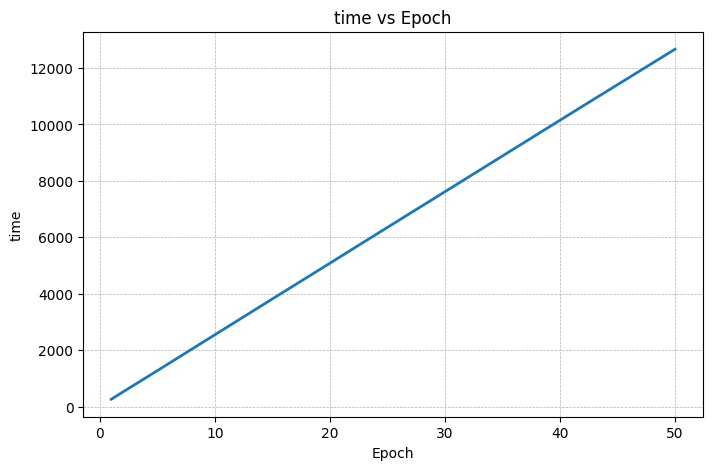

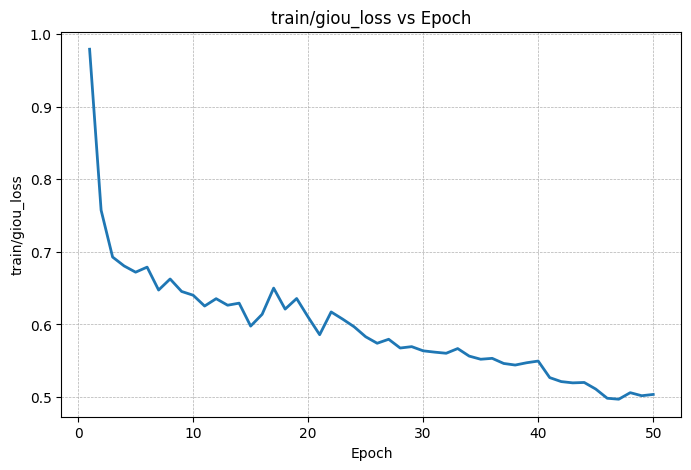

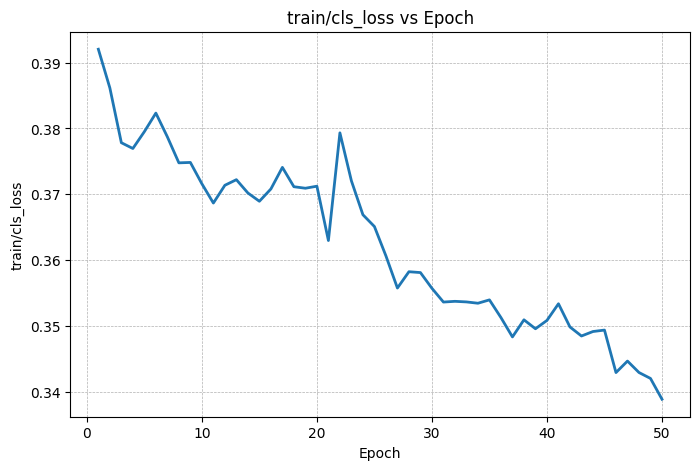

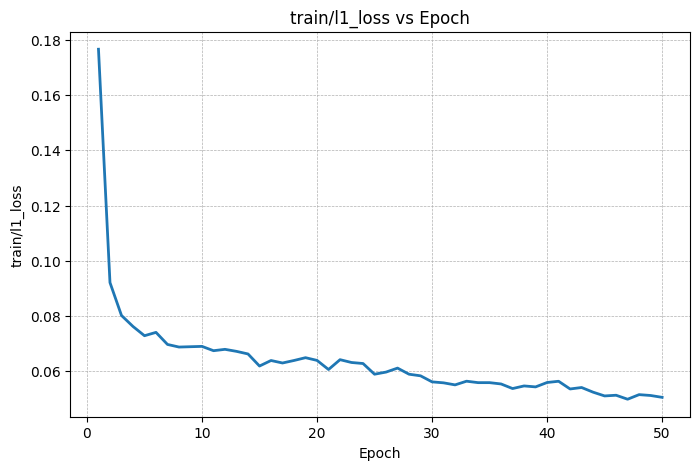

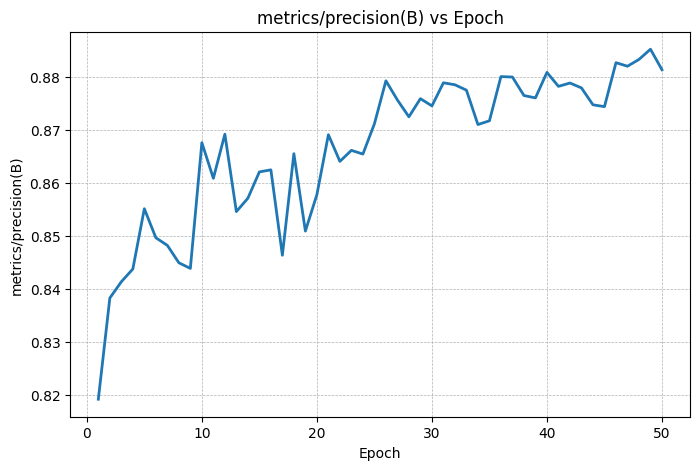

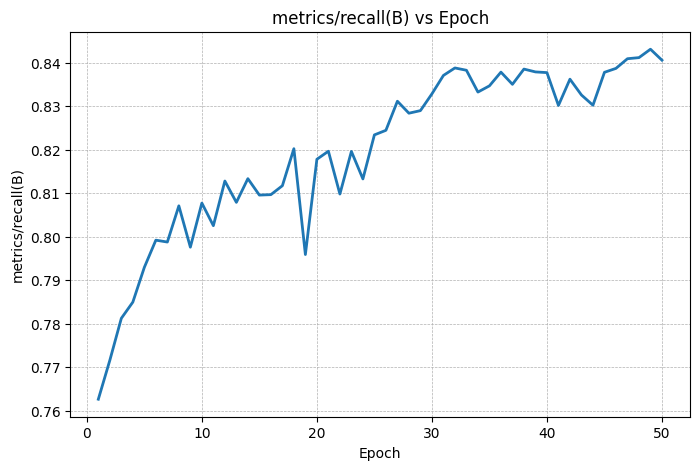

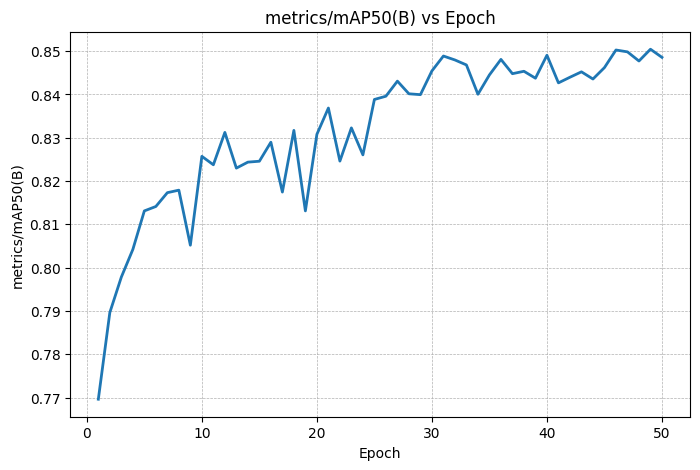

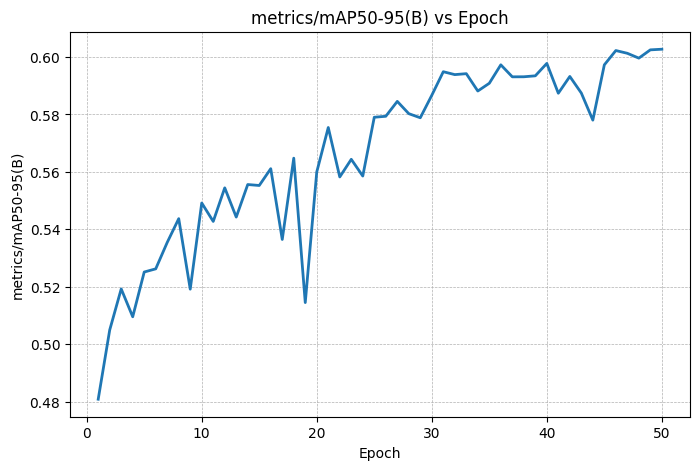

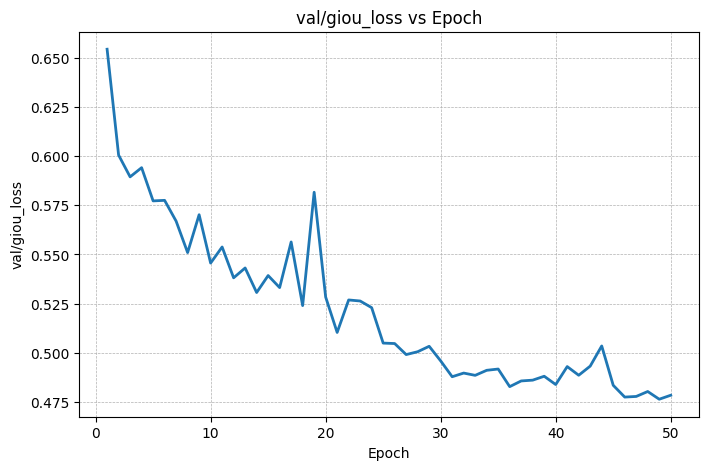

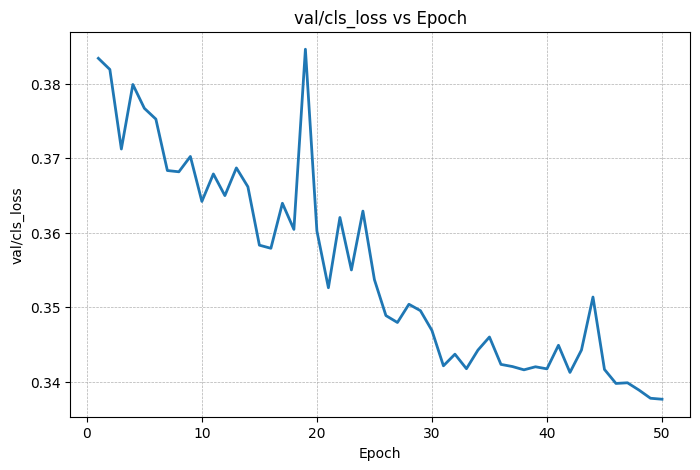

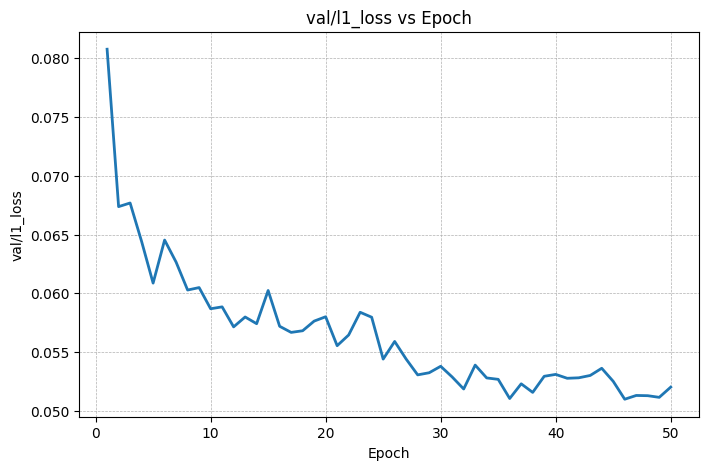

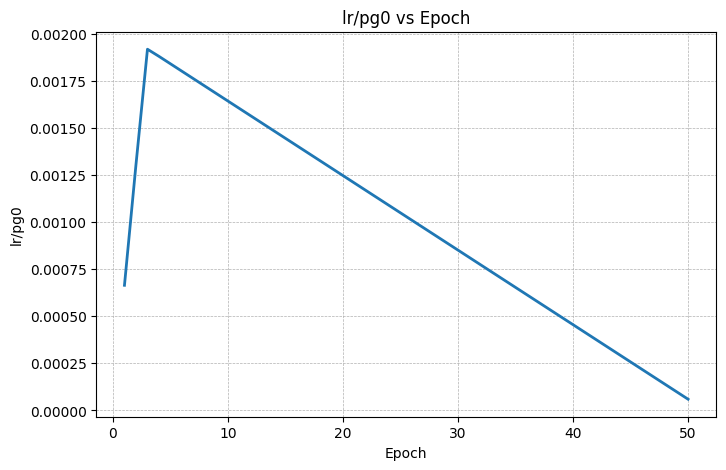

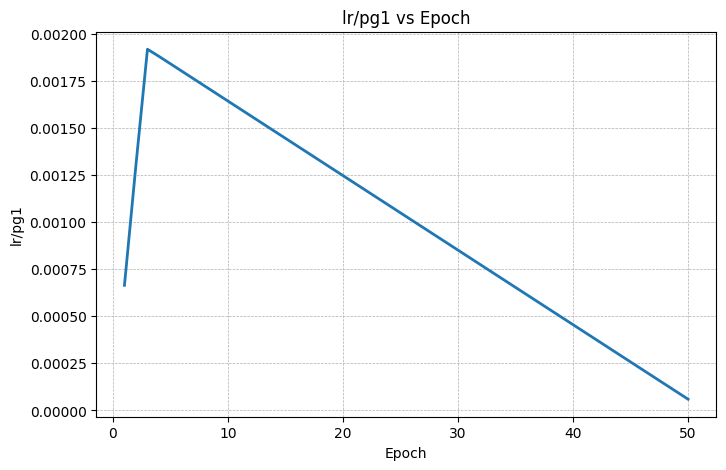

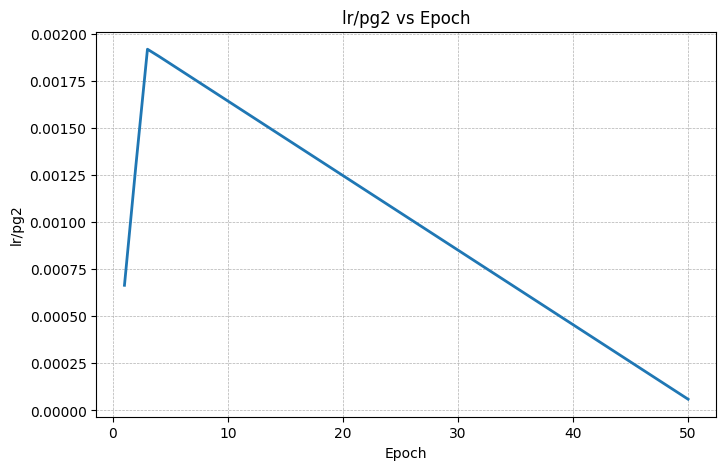

In [7]:
import pandas as pd, matplotlib.pyplot as plt

csv_path = os.path.join(results.save_dir, "results.csv")
df = pd.read_csv(csv_path)
if 'epoch' not in df.columns:
    df.insert(0, 'epoch', range(len(df)))

for col in [c for c in df.columns if c!='epoch']:
    plt.figure(figsize=(8,5)) 
    plt.plot(df['epoch'], df[col], linewidth=2)
    plt.xlabel("Epoch"); plt.ylabel(col); plt.title(f"{col} vs Epoch")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()


In [8]:
#  Get path from results object
best_model_path = os.path.join(results.save_dir, "weights", "best.pt")

# Copy to a fixed known location
shutil.copy(best_model_path, "/kaggle/working/flood_finetuned_best.pt")
print("Finetuned model saved to /kaggle/working/flood_finetuned_best.pt")

Finetuned model saved to /kaggle/working/flood_finetuned_best.pt


In [9]:
# Load the best model
ft_model = YOLO("/kaggle/working/flood_finetuned_best.pt")

# Validate on the flood val set again
ft_metrics = ft_model.val(data=os.path.join(work_dir, "flood.yaml"), split="val", imgsz=960, batch=4)

# Extract metrics
ft_precision = ft_metrics.box.mp
ft_recall    = ft_metrics.box.mr
ft_map50     = ft_metrics.box.map50
ft_map5095   = ft_metrics.box.map

print(f"Precision: {ft_precision:.4f}")
print(f"Recall: {ft_recall:.4f}")
print(f"mAP@0.5: {ft_map50:.4f}")
print(f"mAP@0.5:0.95: {ft_map5095:.4f}")


Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3166.5±1033.8 MB/s, size: 856.0 KB)
val: Scanning /kaggle/working/flood_yolo/labels/val.cache... 542 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 542/542 710.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 136/136 2.9it/s 47.3s0.3ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        542      18562      0.882      0.843      0.851      0.616
Speed: 0.7ms preprocess, 81.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
Precision: 0.8815
Recall: 0.8434
mAP@0.5: 0.8508
mAP@0.5:0.95: 0.6156



image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0332_1.png: 960x960 31 humans, 120.8ms
Speed: 5.0ms preprocess, 120.8ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)


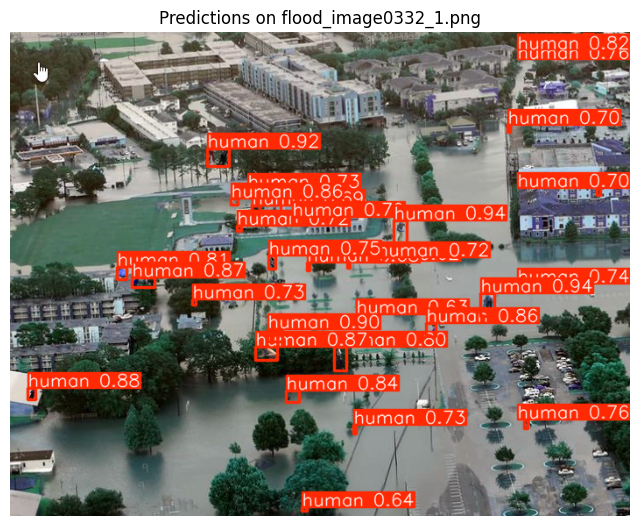


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0454_0.png: 960x960 28 humans, 84.4ms
Speed: 7.1ms preprocess, 84.4ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 960)


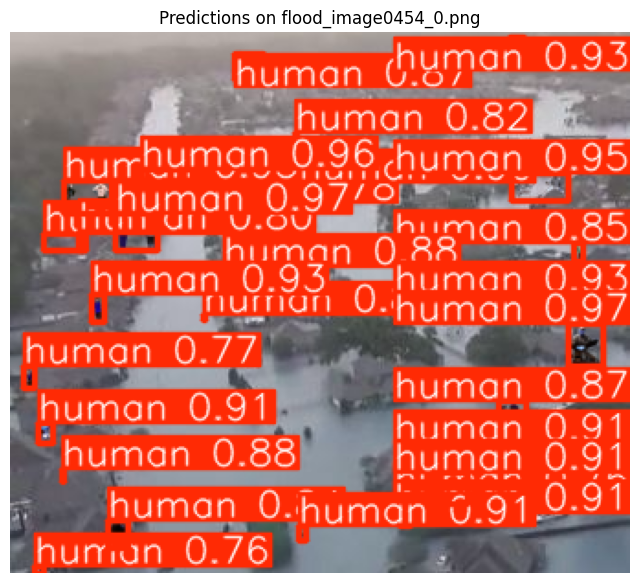


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0163_4.png: 960x960 40 humans, 86.4ms
Speed: 4.6ms preprocess, 86.4ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 960)


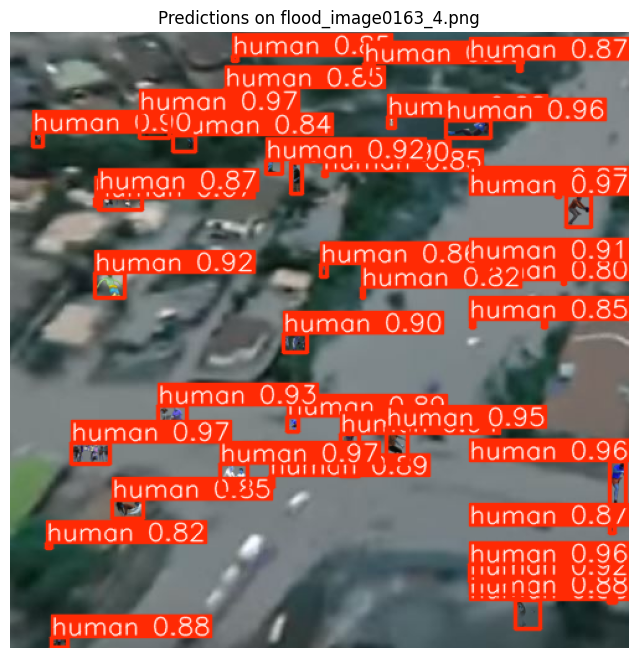


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0464_2.png: 960x960 31 humans, 85.1ms
Speed: 5.9ms preprocess, 85.1ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)


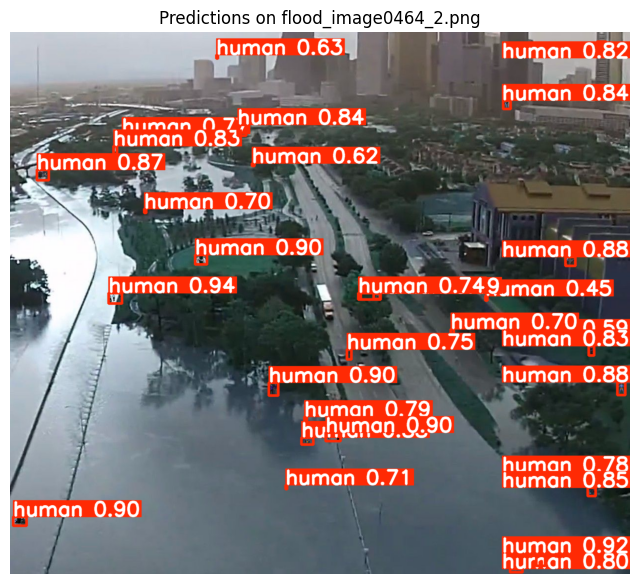


image 1/1 /kaggle/working/flood_yolo/images/val/flood_image0315_3.png: 960x960 19 humans, 84.6ms
Speed: 6.1ms preprocess, 84.6ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 960)


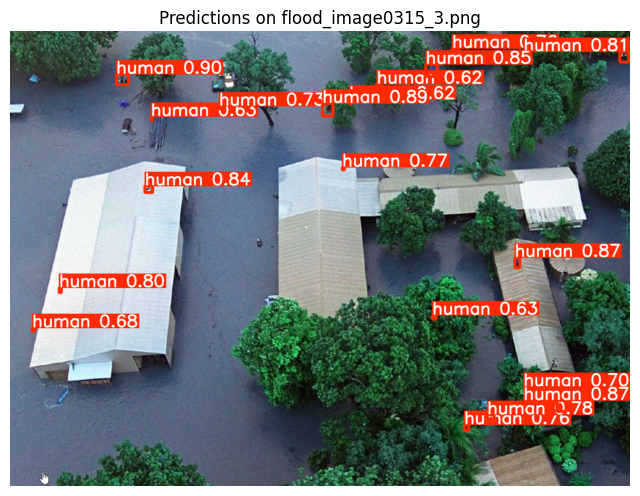

In [10]:
import matplotlib.pyplot as plt
import random

val_images_dir = os.path.join(work_dir, "images/val")
val_images = os.listdir(val_images_dir)
sample_imgs = random.sample(val_images, 5)  # pick 5 random validation images

for img_file in sample_imgs:
    img_path = os.path.join(val_images_dir, img_file)
    results = ft_model.predict(source=img_path, conf=0.4)  # get predictions (conf=0.4 threshold)
    plotted_img = results[0].plot()  # draw boxes on the image
    
    # Display the image with detections
    plt.figure(figsize=(8, 8))
    plt.imshow(plotted_img)
    plt.title(f"Predictions on {img_file}")
    plt.axis('off')
    plt.show()